In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import matplotlib.pyplot as plt
from medcam import medcam
import torch
from torch import nn
from imaging_models.model import MRINet
from pathlib import Path
import pandas as pd
from data_analysis_preparation.utils import filter_df_by_problem
from imaging_models.dataloader import Mri3DDataLoader
import numpy as np
import matplotlib.cm as cm


Using device: mps


In [2]:
MODELS_PATH = r"/Users/michaelhase/Desktop/SeniorThesis/models"
TEST_DATA_PATH = r"/Users/michaelhase/Desktop/SeniorThesis/data/tabular_data/train_base.csv"
OUTPUT_PATH = r"/Users/michaelhase/Desktop/SeniorThesis/output"
problems = {"AD vs CN": ["AD", "CN"] , "AD vs MCI": ["AD", "MCI"], "MCI vs CN": ["MCI", "CN"], "AD vs MCI vs CN": ["MCI", "CN", "AD"], "p-MCI vs np-MCI": ["p-MCI", "np-MCI"]}

In [3]:
def get_injected_model(model_path: str | Path, layer: str, num_classes: int = 2) -> nn.Module:
    """
    Get model with medcam.inject() tracking for GradCAM.
    :param model_path: Path to model weights in .pth format.
    :param layer: Layer identifier. Use medcam.get_layers(model) function to get all layers names.
    :param num_classes: Number of classes.
    :return: Model with tracking.
    """
    model = MRINet(num_classes=num_classes)
    model.to("mps")
    model.eval()
    model.load_state_dict(torch.load(model_path))
    return medcam.inject(model, output_dir=OUTPUT_PATH, layer = layer, return_attention=True)


def get_attention_maps(model: nn.Module, image: torch.Tensor, slice: int = 71) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Get attention map for image and plot it.
    :param model: model with medcam.inject() tracking.
    :param image: image in numpy array format.
    :param slice: slice to plot on each axis.
    :return: tuple of attention maps merged with images for each axis.
    """
    attention_map = model(image.to("cpu"))[1].cpu().numpy()
    image = image.to("cpu").detach().numpy()

    image_axis_0, attention_map_axis_0 = image[0, 0, slice, :, :], attention_map[0, 0, slice, :, :]
    image_axis_1, attention_map_axis_1 = image[0, 0, :, slice, :], attention_map[0, 0, :, slice, :]
    image_axis_2, attention_map_axis_2 = image[0, 0, :, :, slice], attention_map[0, 0, :, :, slice]

    def join(image_2d: np.ndarray, attention_map_2d: np.ndarray) -> np.ndarray:
        """Merge image with attention map."""
        image_2d = np.repeat(image_2d[:, :, np.newaxis], 3, axis=2)
        attention_map_2d = cm.jet(attention_map_2d)[..., :3]
        return attention_map_2d * 0.5 + image_2d * 0.5

    attention_map_axis_0 = join(image_axis_0, attention_map_axis_0)
    attention_map_axis_1 = join(image_axis_1, attention_map_axis_1)
    attention_map_axis_2 = join(image_axis_2, attention_map_axis_2)
    return attention_map_axis_0, attention_map_axis_1, attention_map_axis_2

def get_explanations(model_path: str, dataloader: Mri3DDataLoader, problem_name:str) -> None:
    images = {}
    classes = problems[problem_name]
    model = get_injected_model(model_path, 'stem', num_classes=len(classes))

    for class_id, class_name in enumerate(classes):
        for batch in dataloader:
            if class_id == np.argmax(batch[1].cpu().numpy()):
                images[(class_id, class_name)] = batch[0]
                break

    plt.figure(figsize=(10, 10))
    for (class_id, class_name), image in images.items():
        attention_map_axis_0, attention_map_axis_1, attention_map_axis_2 = get_attention_maps(model, image)
        plt.subplot(len(classes), 3, class_id * 3 + 1)
        plt.imshow(attention_map_axis_0)
        plt.title(class_name)
        plt.subplot(len(classes), 3, class_id * 3 + 2)
        plt.imshow(attention_map_axis_1)
        plt.title(class_name)
        plt.subplot(len(classes), 3, class_id * 3 + 3)
        plt.imshow(attention_map_axis_2)
        plt.title(class_name)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, f"{problem_name}.png"))
    plt.show()



## AD vs CN

In [4]:
test_df = pd.read_csv(TEST_DATA_PATH)
dataloader = Mri3DDataLoader(filter_df_by_problem("AD vs CN", test_df), classification_values=["AD", "CN"], batch_size=1)
model_path = os.path.join(MODELS_PATH, "AD vs CN", "best_model.pth")

/var/folders/16/v2y5n0097wvcclskn_5f_8hm0000gn/T/ipykernel_91389/4255879030.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)

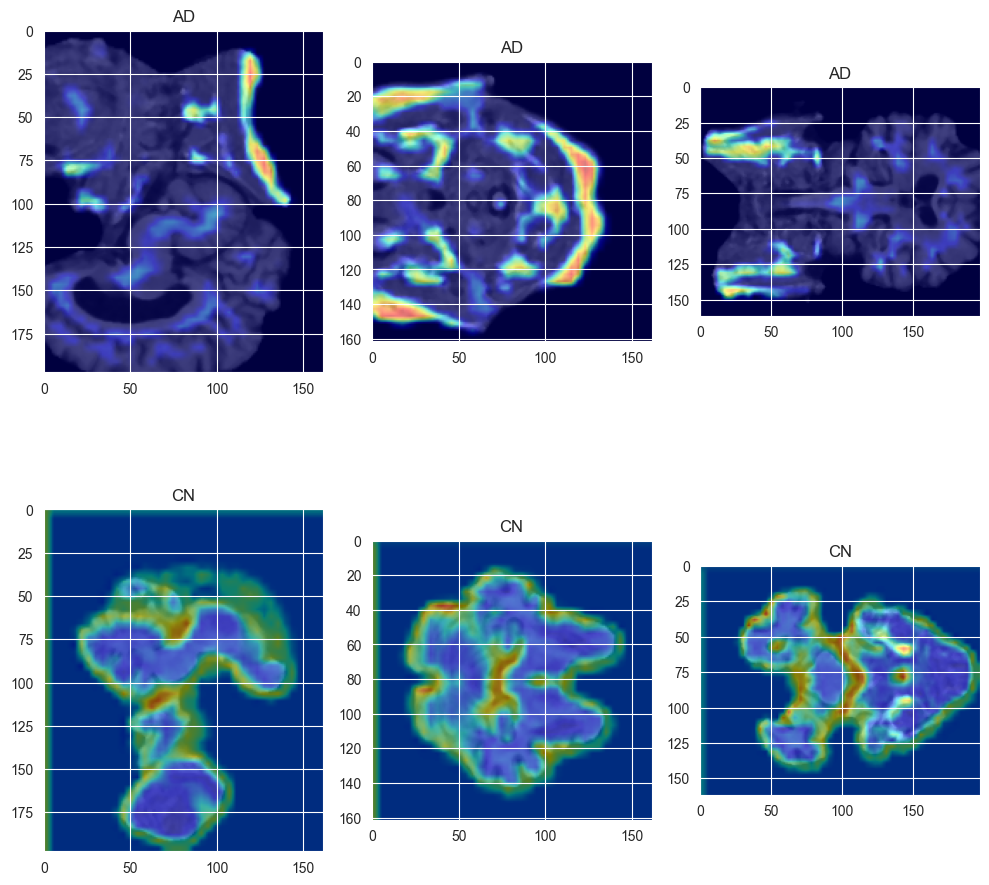

In [5]:

get_explanations(model_path, dataloader, "AD vs CN")

## AD vs MCI

In [6]:
test_df = pd.read_csv(TEST_DATA_PATH)
dataloader = Mri3DDataLoader(filter_df_by_problem("AD vs MCI", test_df), classification_values=["AD", "MCI"], batch_size=1)
model_path = os.path.join(MODELS_PATH, "AD vs MCI", "best_model.pth")

/var/folders/16/v2y5n0097wvcclskn_5f_8hm0000gn/T/ipykernel_91389/4255879030.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)

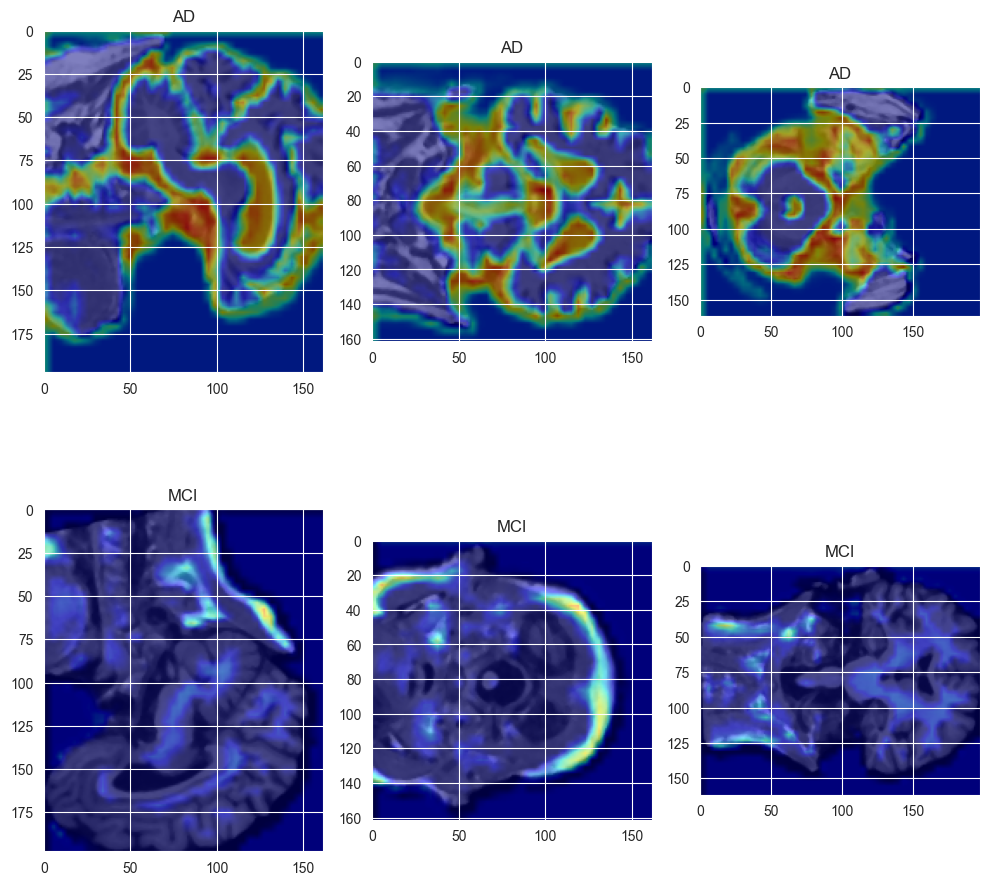

In [7]:
get_explanations(model_path, dataloader, "AD vs MCI")

### MCI vs CN

In [8]:
test_df = pd.read_csv(TEST_DATA_PATH)
dataloader = Mri3DDataLoader(filter_df_by_problem("MCI vs CN", test_df), classification_values=["MCI", "CN"], batch_size=1)
model_path = os.path.join(MODELS_PATH, "MCI vs CN", "best_model.pth")

/var/folders/16/v2y5n0097wvcclskn_5f_8hm0000gn/T/ipykernel_91389/4255879030.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)

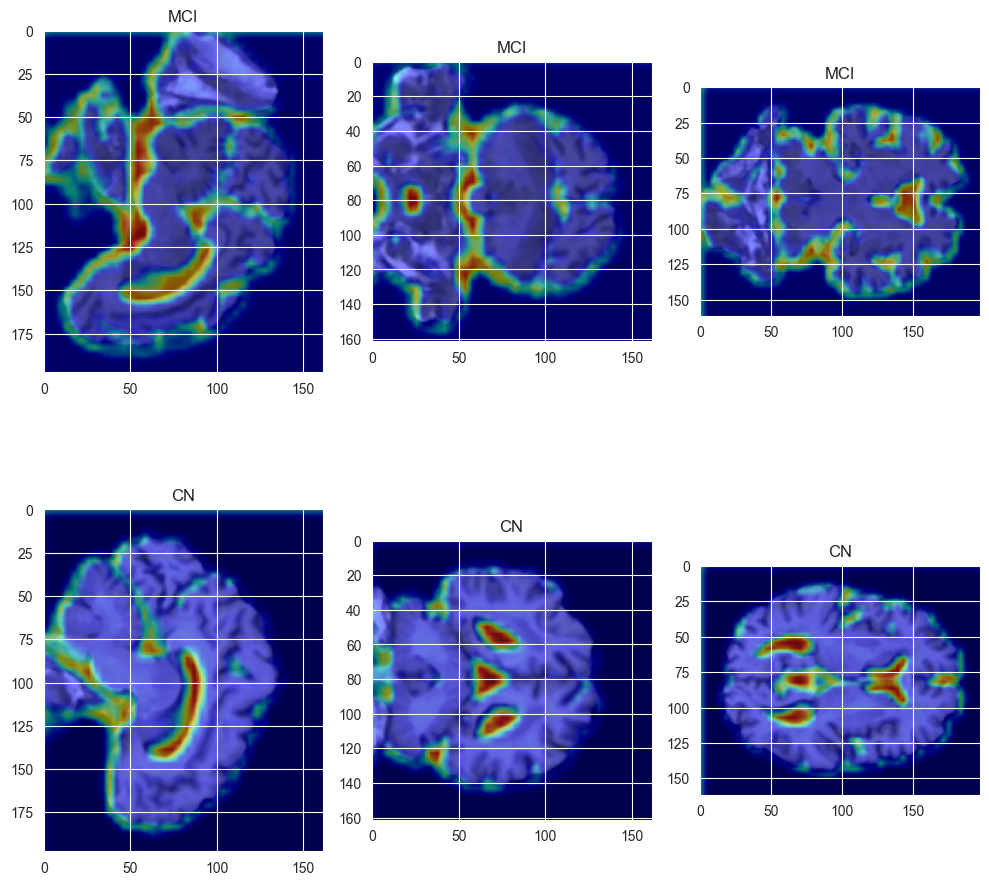

In [9]:
get_explanations(model_path, dataloader, "MCI vs CN")

### AD vs MCI vs CN

In [10]:
test_df = pd.read_csv(TEST_DATA_PATH)
dataloader = Mri3DDataLoader(filter_df_by_problem("AD vs MCI vs CN", test_df), classification_values=["AD", "MCI", "CN"], batch_size=1)
model_path = os.path.join(MODELS_PATH, "AD vs MCI vs CN", "best_model.pth")

/var/folders/16/v2y5n0097wvcclskn_5f_8hm0000gn/T/ipykernel_91389/4255879030.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)

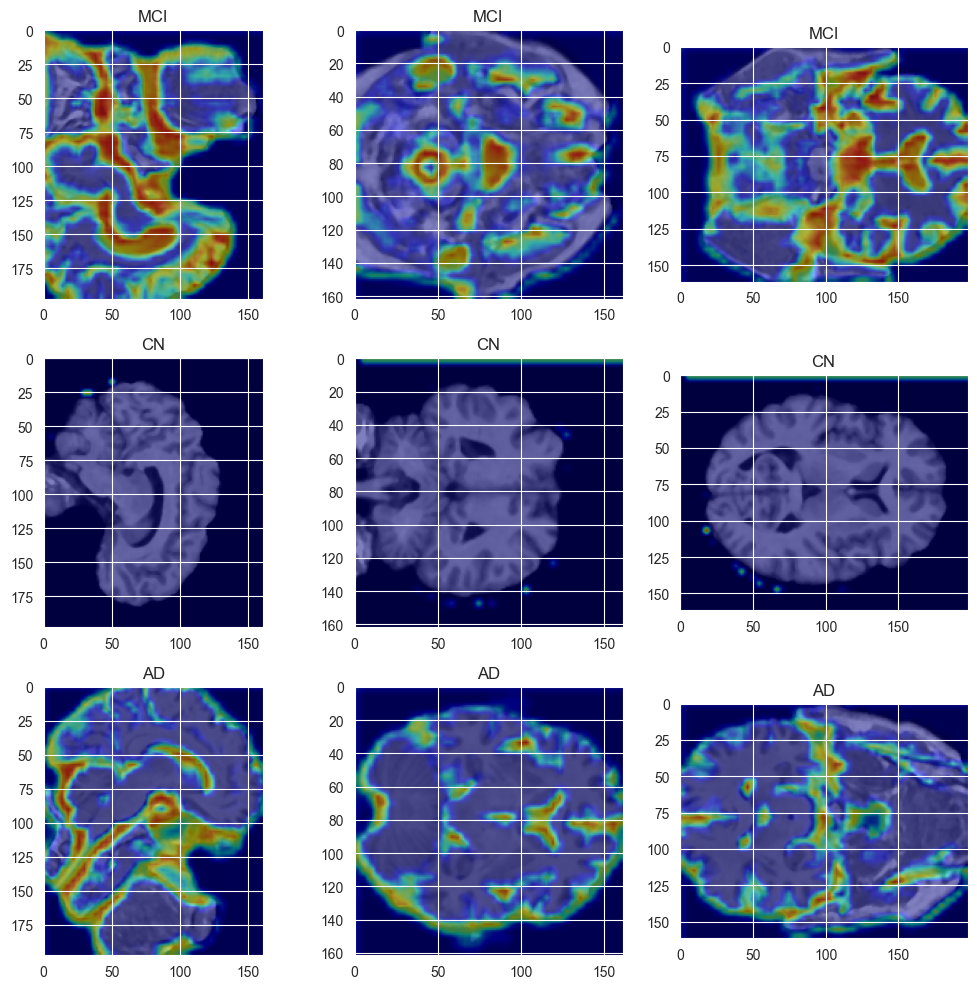

In [11]:
get_explanations(model_path, dataloader, "AD vs MCI vs CN")

### p-MCI vs np-MCI

In [12]:
test_df = pd.read_csv(TEST_DATA_PATH)
dataloader = Mri3DDataLoader(filter_df_by_problem("p-MCI vs np-MCI", test_df), classification_values=["p-MCI", "np-MCI"], batch_size=1)
model_path = os.path.join(MODELS_PATH, "p-MCI vs np-MCI", "best_model.pth")

/var/folders/16/v2y5n0097wvcclskn_5f_8hm0000gn/T/ipykernel_91389/4255879030.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)

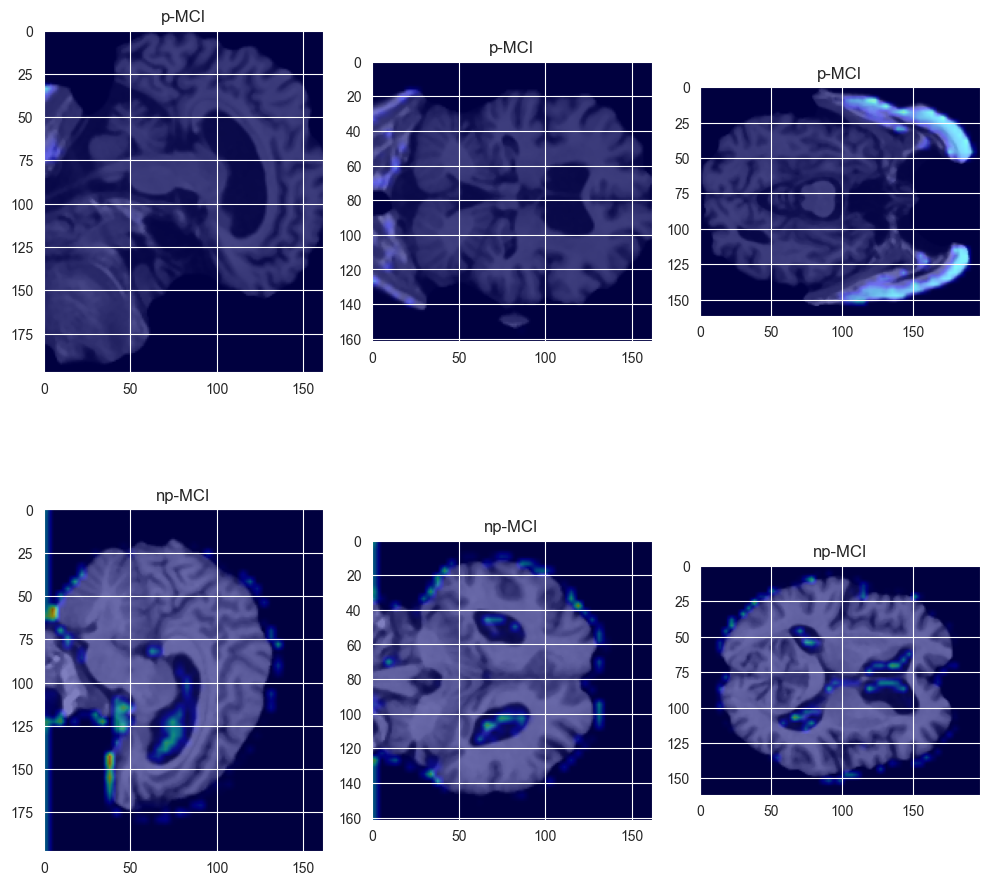

In [13]:
get_explanations(model_path, dataloader, "p-MCI vs np-MCI")